In [1]:
%cd ../..
%load_ext autoreload

%autoreload 2

/home/giacomowsl/Projects/sinergia/emplusvault


In [2]:
import os
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from rts.features.pose import compute_human_angles, reshape_keypoints
import rts.features.pose as pose
import umap
import cv2

/home/giacomowsl/.cache/pypoetry/virtualenvs/rts-o0uzL038-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
poses_folder = "data/test_poses/"
poses_jl = [poses_folder + f for f in os.listdir(poses_folder)]
poses = []
for pose_json in poses_jl:
    extracted_data = pose.extract_frame_data(pose_json, 0.5)
    if len(extracted_data.keys()) > 0:
        pose_exp = [[{"frame_number":k, "angle_vec":angle, "keypoints":keypoint, "bbox":bbox} for angle,keypoint,bbox in zip(v["angle_vec"], v["keypoints"], v["bbox"])] for k,v in extracted_data.items()]
        pose_exp = [item for sublist in pose_exp for item in sublist]
        [p.update({"video_name":pose_json.split("/")[-1].split(".")[0]}) for p in pose_exp]
        poses.extend(pose_exp)

print(len(poses))

14311


In [4]:
reducer = umap.UMAP(n_neighbors=250, min_dist=0.1, metric='cosine')
pose_df = pd.DataFrame(poses)
embeddings = reducer.fit_transform(pose_df["angle_vec"].tolist())
pose_df["umap_x"] = embeddings[:,0]
pose_df["umap_y"] = embeddings[:,1]

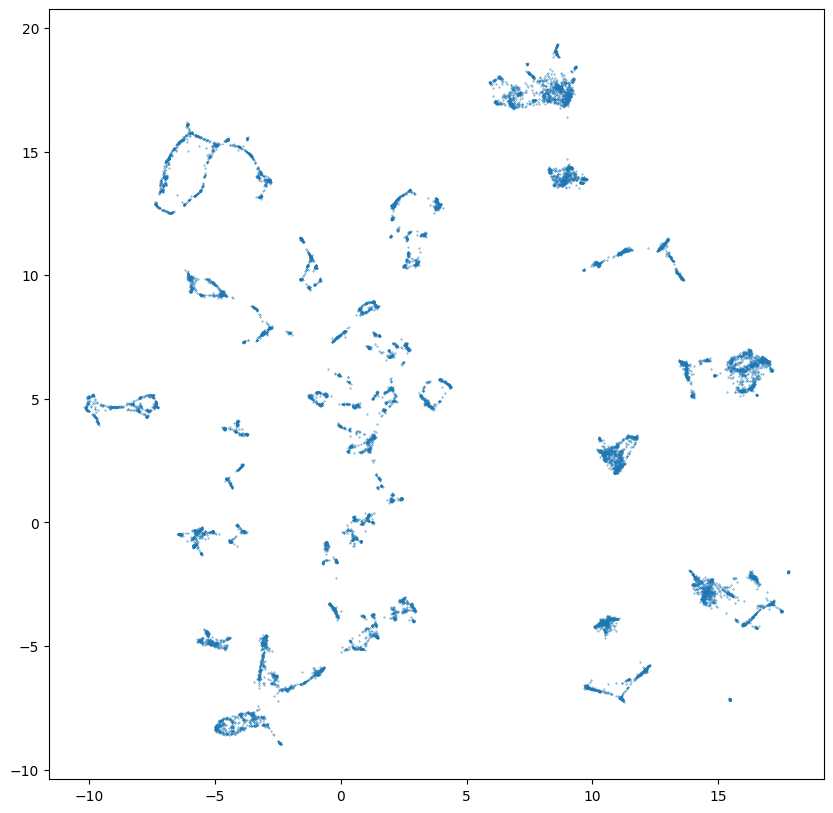

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(pose_df["umap_x"], pose_df["umap_y"], s=0.1)
plt.show()

# Clustering

In [6]:
from sklearn.cluster import DBSCAN, KMeans

In [21]:
def cluster_poses(algo, pose_df):
    algo.fit(pose_df[["umap_x", "umap_y"]])
    pose_df["label"] = algo.labels_
    plt.figure(figsize=(10,10))
    for label in pose_df["label"].unique():
        plt.scatter(pose_df[pose_df.label == label]["umap_x"], pose_df[pose_df.label == label]["umap_y"], s=0.1*(label + 1), label=label)
    plt.legend(markerscale = 10)
    plt.show()

    return pose_df

/home/giacomowsl/.cache/pypoetry/virtualenvs/rts-o0uzL038-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


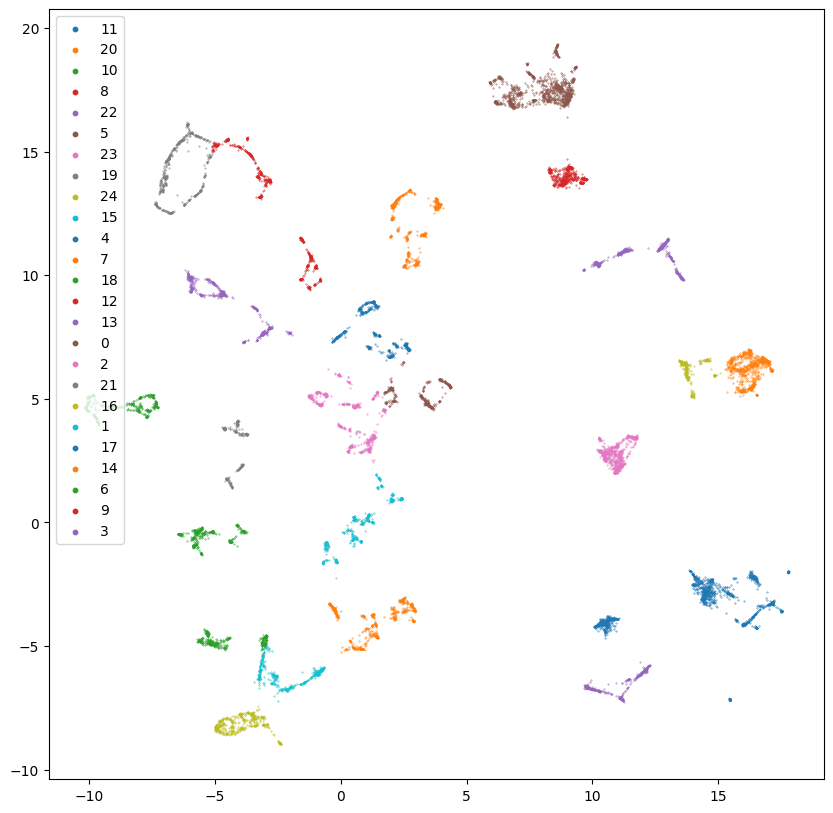

In [16]:
kmeans = KMeans(n_clusters=25)
kmeans_poses = cluster_poses(kmeans, pose_df)

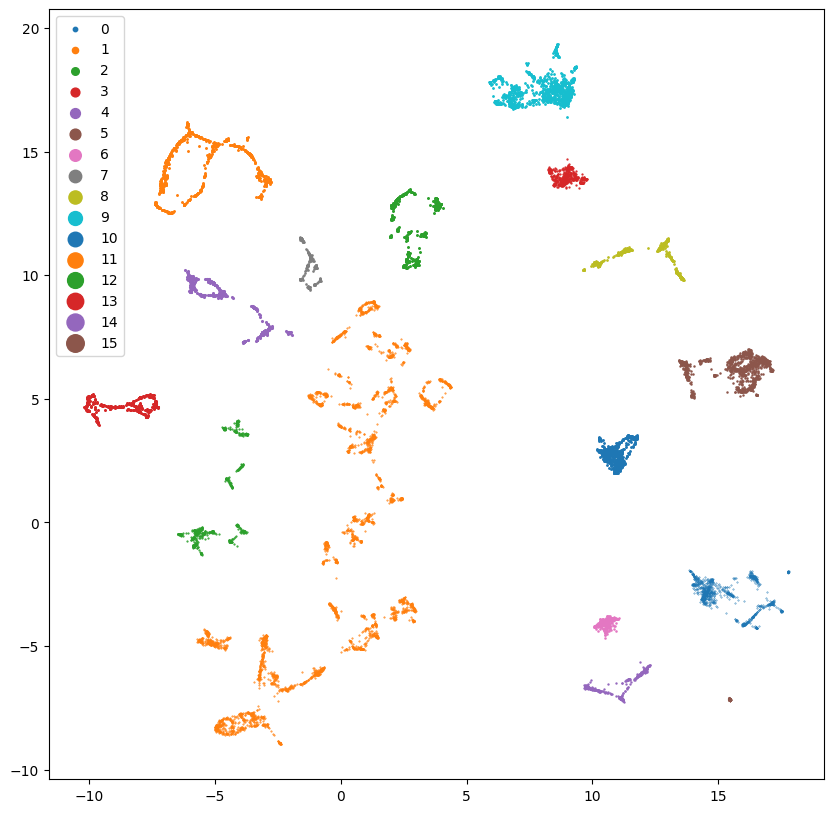

In [22]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_poses = cluster_poses(dbscan, pose_df)

In [10]:
KEYPOINTS_NAMES = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", 
                   "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", 
                   "left_wrist", "right_wrist", "left_hip", "right_hip", 
                   "left_knee", "right_knee", "left_ankle", "right_ankle"]

CONNECTIONS = [
    ("nose", "left_eye"),
    ("nose", "right_eye"),
    ("left_eye", "left_ear"),
    ("right_eye", "right_ear"),
    ("left_shoulder", "right_shoulder"),
    ("left_shoulder", "left_elbow"),
    ("right_shoulder", "right_elbow"),
    ("left_elbow", "left_wrist"),
    ("right_elbow", "right_wrist"),
    ("left_hip", "right_hip"),
    ("left_hip", "left_knee"),
    ("right_hip", "right_knee"),
    ("left_knee", "left_ankle"),
    ("right_knee", "right_ankle"),
    ("left_shoulder", "left_hip"),
    ("right_shoulder", "right_hip")
]

In [11]:
sequences_folder = "/mnt/g/ioc/sequences/"

def get_frame(video_name, frame_number):
    video_path = [f for f in os.listdir(sequences_folder + video_name) if f.endswith(".mp4")][0]
    cap = cv2.VideoCapture(sequences_folder + video_name + "/" + video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [12]:
def draw_pose(pose, ax = None, cut=True, threshold=0.1):
    keypoints = pose["keypoints"]

    # Do not draw non-detected keypoints
    #connections = [c for c in connections if keypoints[KEYPOINTS_NAMES.index(c[0])][2] > threshold and keypoints[KEYPOINTS_NAMES.index(c[1])][2] > threshold]
    #keypoints = [k for k in keypoints if k[2] > threshold]
    
    frame = get_frame(pose["video_name"], pose["frame_number"])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    ax.imshow(frame)
    ax.scatter([k[0] for k in keypoints if k[2] > threshold], [k[1] for k in keypoints if k[2] > threshold], s=10)
    for c in CONNECTIONS:
        k1 = keypoints[KEYPOINTS_NAMES.index(c[0])]
        k2 = keypoints[KEYPOINTS_NAMES.index(c[1])]
        if k1[2] > threshold and k2[2] > threshold:
            ax.plot([k1[0], k2[0]], 
                    [k1[1], k2[1]], 
                    linewidth=1, color='black')
        
    # cut frame to bbox
    bbox = pose["bbox"]
    if cut:
        ax.set_xlim(int(bbox[0]),int(bbox[0] + bbox[2]))
        ax.set_ylim(int(bbox[1] + bbox[3]), int(bbox[1]))

    ax.axis("off")
    ax.set_aspect('equal')
    plt.tight_layout()

    return ax


In [ ]:
# create a grid of subplots
nrows = 2
ncols = 6

for cluster in dbscan_poses["label"].unique():
    print("Cluster", cluster)
    n_samples = dbscan_poses[dbscan_poses["label"] == cluster].shape[0]
    n_samples = min(n_samples, nrows * ncols)
    sample_poses = dbscan_poses[dbscan_poses["label"] == cluster].sample(n_samples).reset_index(drop=True)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))
    axs = axs.flatten()
    # iterate over the poses and draw each pose in a subplot
    for i, pose in sample_poses.iterrows():
        draw_pose(pose, ax = axs[i], cut = True)

    plt.show()
